In [1]:
from pyspark import SparkContext, SparkConf 
from pyspark.sql import SparkSession
import numpy as np
import math
spark = SparkSession \
    .builder \
    .appName("Fava_Project") \
    .master("local[4]") \
    .getOrCreate()
sc=spark.sparkContext

23/01/18 21:53:01 WARN Utils: Your hostname, diablo resolves to a loopback address: 127.0.1.1; using 192.168.1.105 instead (on interface wlp3s0)
23/01/18 21:53:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/18 21:53:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df=spark.read.csv('TrafficData.csv',header=True) # Sample_Traffic.csv Traffic.csv
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|   22010122|      284|       97955760|     64111706|               7|       161|2022-01-10 08:58:02|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



In [3]:
import pandas as pd
from pyspark.sql.functions import col,current_timestamp,to_date,hour,dayofweek
from datetime import datetime

df.select(to_date(col('PASS_DAY_TIME'))).distinct().collect()

[Row(to_date(PASS_DAY_TIME)=datetime.date(2022, 1, 9)),
 Row(to_date(PASS_DAY_TIME)=datetime.date(2022, 1, 10)),
 Row(to_date(PASS_DAY_TIME)=datetime.date(2022, 1, 8)),
 Row(to_date(PASS_DAY_TIME)=datetime.date(2022, 1, 13)),
 Row(to_date(PASS_DAY_TIME)=datetime.date(2022, 1, 14)),
 Row(to_date(PASS_DAY_TIME)=datetime.date(2022, 1, 12)),
 Row(to_date(PASS_DAY_TIME)=datetime.date(2022, 1, 11))]

# **الف**

In [4]:
device_rdd=df.select('DEVICE_CODE').rdd
DEVICE_CODE_index_rdd=device_rdd.distinct().map(lambda x:x.asDict()['DEVICE_CODE']).zipWithIndex()#.map(lambda x:{x[0]:x[1]}).collect()
DEVICE_CODE_index=sc.broadcast(dict(DEVICE_CODE_index_rdd.map(lambda x:(x[0],x[1])).collect()))
index_DEVICE_CODE=sc.broadcast(dict(DEVICE_CODE_index_rdd.map(lambda x:(x[1],x[0])).collect()))

In [5]:
header=sc.textFile("TrafficData.csv").first()

RDD=sc.textFile("TrafficData.csv").filter(lambda l :not str(l).startswith(header))

Traffic_RDD=RDD.map(lambda x:x.split(',')).map(lambda x:((int(x[2]),int("".join(x[-1].split()[0].split('-')))),DEVICE_CODE_index.value[x[0]])).groupByKey().mapValues(lambda x:list(set(x)))

In [6]:
selectedCamera=[['900120'],
 ['900214'],
 ['900212'],
 ['900101'],
 ['900244'],
 ['900142']]

# **ب**

In [7]:

Hypothetica_path=list(map(lambda x:DEVICE_CODE_index.value[x[0]],selectedCamera))
Hypothetica_path=sc.broadcast(Hypothetica_path)

In [8]:

def cosineDistance(x):
    abs_x=len(x[1])**0.5
    abs_H=len(Hypothetica_path.value)**0.5
    dot_operator=len(list(set(x[1]) & set(Hypothetica_path.value)))
    theta=math.acos(dot_operator/(abs_x*abs_H))
    sim=1-theta/math.pi
    return (x[0],x[1],sim)


In [9]:
Traffic_RDD.map(cosineDistance).top(num=10,key=lambda x:x[2])

[((9815266, 20220108), [1, 803, 227, 44, 532, 729], 0.8135705013226627),
 ((52566321, 20220113), [1, 227, 803, 532, 88, 729], 0.8135705013226627),
 ((19423926, 20220108), [1, 803, 532, 729], 0.8040867239846964),
 ((8007880, 20220108), [1, 227, 532, 803], 0.8040867239846964),
 ((76136178, 20220110), [1, 803, 729, 227], 0.8040867239846964),
 ((20268928, 20220110), [1, 227, 532, 803], 0.8040867239846964),
 ((14474545, 20220111), [729, 803, 1, 227], 0.8040867239846964),
 ((10753850, 20220112), [1, 803, 532, 227], 0.8040867239846964),
 ((8720813, 20220113), [803, 227, 532, 1], 0.8040867239846964),
 ((88514534, 20220112), [729, 803, 1, 227], 0.8040867239846964)]

In [10]:
true_similar_count=Traffic_RDD.map(cosineDistance).filter(lambda x:x[2]>=0.7).count()
true_non_similar_count=Traffic_RDD.map(cosineDistance).filter(lambda x:x[2]<0.7).count()
print("Number of  true similar vehicle beyond threshold is : ",true_similar_count)
print("Number of  true non similar vehicle less than threshold is : ",true_non_similar_count)

Number of  true similar vehicle beyond threshold is :  52551
Number of  true non similar vehicle less than threshold is :  12337108


# **ج**

## Result 100 Hash function 6 and then 12 OR

### Random Hyperplane

In [11]:
# Hash Function 
totalSignatureLength=6*12
Band_num=12
Row=int(totalSignatureLength/Band_num)
total_shingles_num=len(DEVICE_CODE_index.value.keys())

np.random.seed(101)
H=sc.broadcast(2*np.random.randint(0,2,size=(totalSignatureLength,total_shingles_num),dtype='int8',)-1)





Hypothetica_path=list(map(lambda x:DEVICE_CODE_index.value[x[0]],selectedCamera))
Hypothetica_path=sc.broadcast(Hypothetica_path)

### Used Functions

In [12]:
def sketch(x):
    S=np.sign(np.sum(H.value[:,x[1]],axis=1)).reshape(Band_num,Row)
    O=[]
    for i in range(Band_num):
        O.append(((i,hash(S[i,:])),x))
    return O
def hash(x):
    x[x==-1]=0
    h=0
    for i in range(len(x)):
        h+=2**(i)*x[i]
    return h
def to_list(a):
    return [a]

def append(a, b):
    a.append(b)
    return a

def extend(a, b):
    a.extend(b)
    return a


def cosineDistance(x):
    abs_x=len(x[1])**0.5
    abs_H=len(Hypothetica_path.value)**0.5
    dot_operator=len(list(set(x[1]) & set(Hypothetica_path.value)))
    theta=math.acos(dot_operator/(abs_x*abs_H))
    sim=1-theta/math.pi
    return (x[0],x[1],sim)

### Run LSH Algorithm

In [13]:
Query_bucket=sketch(('Query',Hypothetica_path.value))
Query_bucket=sc.broadcast(list(map(lambda x:tuple(x),np.array(Query_bucket,dtype=object)[:,0].tolist())))

similarVehiclesRDD=Traffic_RDD.flatMap(sketch).filter(lambda x:x[0] in Query_bucket.value).map(lambda x: x[1]).map(cosineDistance)


In [14]:
similarVehiclesRDD.filter(lambda x:x[2]>=0.7).map(lambda x: (x[0],tuple(x[1]),x[2])).distinct().top(num=10,key=lambda x:x[2])


[((9815266, 20220108), (1, 803, 227, 44, 532, 729), 0.8135705013226627),
 ((52566321, 20220113), (1, 227, 803, 532, 88, 729), 0.8135705013226627),
 ((86372717, 20220113), (729, 803, 532, 1), 0.8040867239846964),
 ((7635855, 20220114), (729, 227, 1, 803), 0.8040867239846964),
 ((85096101, 20220113), (1, 227, 532, 803), 0.8040867239846964),
 ((10208309, 20220109), (1, 227, 532, 803), 0.8040867239846964),
 ((8409377, 20220113), (1, 803, 532, 227), 0.8040867239846964),
 ((8581829, 20220111), (1, 803, 532, 227), 0.8040867239846964),
 ((8253951, 20220113), (1, 803, 532, 227), 0.8040867239846964),
 ((10877013, 20220114), (729, 803, 1, 227), 0.8040867239846964)]

In [15]:
true_similar_count=similarVehiclesRDD.filter(lambda x:x[2]>=0.7).map(lambda x: x[0]).distinct().count()
true_non_similar_count=similarVehiclesRDD.filter(lambda x:x[2]<0.7).map(lambda x: x[0]).distinct().count()


In [16]:
print("Result for 6 And then 12 OR 72 Hash in total")
print("Number of  true similar vehicle beyond threshold is : ",true_similar_count)
print("Number of  true non similar vehicle less than threshold is : ",true_non_similar_count)

Result for 6 And then 12 OR 72 Hash in total
Number of  true similar vehicle beyond threshold is :  50103
Number of  true non similar vehicle less than threshold is :  2949285


## Result 64 Hash function 4 and then 8 OR

### Random Hyperplane

In [17]:
# Hash Function 
totalSignatureLength=4*8
Band_num=8
Row=int(totalSignatureLength/Band_num)
total_shingles_num=len(DEVICE_CODE_index.value.keys())

np.random.seed(101)
H=sc.broadcast(2*np.random.randint(0,2,size=(totalSignatureLength,total_shingles_num),dtype='int8',)-1)





Hypothetica_path=list(map(lambda x:DEVICE_CODE_index.value[x[0]],selectedCamera))
Hypothetica_path=sc.broadcast(Hypothetica_path)

### Used Functions

In [18]:

def sketch(x):
    S=np.sign(np.sum(H.value[:,x[1]],axis=1)).reshape(Band_num,Row)
    O=[]
    for i in range(Band_num):
        O.append(((i,hash(S[i,:])),x))
    return O
def hash(x):
    x[x==-1]=0
    h=0
    for i in range(len(x)):
        h+=2**(i)*x[i]
    return h
def to_list(a):
    return [a]

def append(a, b):
    a.append(b)
    return a

def extend(a, b):
    a.extend(b)
    return a


def cosineDistance(x):
    abs_x=len(x[1])**0.5
    abs_H=len(Hypothetica_path.value)**0.5
    dot_operator=len(list(set(x[1]) & set(Hypothetica_path.value)))
    theta=math.acos(dot_operator/(abs_x*abs_H))
    sim=1-theta/math.pi
    return (x[0],x[1],sim)

### Run LSH Algorithm

In [19]:

Query_bucket=sketch(('Query',Hypothetica_path.value))
Query_bucket=sc.broadcast(list(map(lambda x:tuple(x),np.array(Query_bucket,dtype=object)[:,0].tolist())))
   
similarVehiclesRDD=Traffic_RDD.flatMap(sketch).filter(lambda x:x[0] in Query_bucket.value).map(lambda x: x[1]).map(cosineDistance)




In [20]:
similarVehiclesRDD.filter(lambda x:x[2]>=0.7).map(lambda x: (x[0],tuple(x[1]),x[2])).distinct().top(num=10,key=lambda x:x[2])


[((9815266, 20220108), (1, 803, 227, 44, 532, 729), 0.8135705013226627),
 ((52566321, 20220113), (1, 227, 803, 532, 88, 729), 0.8135705013226627),
 ((86372717, 20220113), (729, 803, 532, 1), 0.8040867239846964),
 ((7635855, 20220114), (729, 227, 1, 803), 0.8040867239846964),
 ((85096101, 20220113), (1, 227, 532, 803), 0.8040867239846964),
 ((10208309, 20220109), (1, 227, 532, 803), 0.8040867239846964),
 ((8409377, 20220113), (1, 803, 532, 227), 0.8040867239846964),
 ((8581829, 20220111), (1, 803, 532, 227), 0.8040867239846964),
 ((8253951, 20220113), (1, 803, 532, 227), 0.8040867239846964),
 ((10877013, 20220114), (729, 803, 1, 227), 0.8040867239846964)]

In [21]:
true_similar_count=similarVehiclesRDD.filter(lambda x:x[2]>=0.7).map(lambda x: x[0]).distinct().count()
true_non_similar_count=similarVehiclesRDD.filter(lambda x:x[2]<0.7).map(lambda x: x[0]).distinct().count()


In [22]:
print("Result for 4 And then 8 OR 32 Hash in total")
print("Number of  true similar vehicle beyond threshold is : ",true_similar_count)
print("Number of  true non similar vehicle less than threshold is : ",true_non_similar_count)

Result for 4 And then 8 OR 32 Hash in total
Number of  true similar vehicle beyond threshold is :  50698
Number of  true non similar vehicle less than threshold is :  6724571


## comparison of two methods

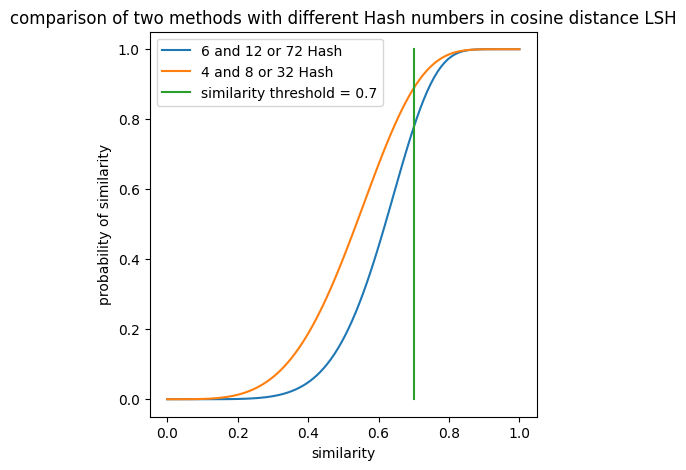

In [24]:
import matplotlib.pyplot as plt
x=np.linspace(start=0,stop=1.0,num=100)
y1=1-(1-x**6)**12
y2=1-(1-x**4)**8
plt.figure(figsize=(5,5))

plt.plot(x,y1)
plt.plot(x,y2)
plt.plot([0.7,0.7],[0,1])
plt.legend(["6 and 12 or 72 Hash","4 and 8 or 32 Hash","similarity threshold = 0.7"])

plt.xlabel('similarity')
plt.ylabel('probability of similarity')
_=plt.title('comparison of two methods with different Hash numbers in cosine distance LSH')